# ERPs Analysis
In this notebook, we take the MATLAB files containing each subject's trials ERPs average per category. We analyse it to find the differences in hiher and lower peak latency across categories after stimulus onset.

### 1. Load data

In [599]:
from os.path import dirname, join as pjoin
import scipy.io as sio
from operator import itemgetter
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from matplotlib.ticker import FormatStrFormatter

import pandas as pd
import pyxdf
import dataframe_image as dfi
import seaborn as sns

In [611]:
data_path  = "data/erps"
erps_file = pjoin(data_path, "mean_activation_all_2_sub_PO8.mat")
erps_content = sio.loadmat(erps_file)

In [612]:
len(erps_content['erps_body'][0])

358

In [673]:
ch_keys = ["erps_body","erps_face","erps_object","subj_time"]

df = pd.DataFrame(columns=np.concatenate([ch_keys]))
# df = pd.DataFrame()
for i, name in enumerate(ch_keys):
    items = itemgetter(*ch_keys)(dict(erps_content))
    # items = [item[0] if isinstance(item, list) else item for i, item in enumerate(items)]

# WORKS but gives a very bad structured dataframe
df = df.append(pd.Series(items, index=ch_keys), ignore_index=True)

# I must add an extra column "subject" that adds a number (for each array found) of the size of the dataframe
# the dataset I am working with has 2 subjects, thus 2 arrays per category.
# df['sub'] = np.resize(i,len(erps_content[name][i]))
df

,erps_body,erps_face,erps_object,subj_time
0,"[[-0.5678685307502747, -0.22752249240875244, -...","[[0.07909755408763885, 0.2685020864009857, 0.5...","[[-0.9528565406799316, -0.7579599618911743, -0...","[[-199.21875, -197.265625, -195.3125, -193.359..."


In [614]:
# This is a less generaic way to create the dataframe
df1 = pd.DataFrame(columns=np.concatenate([ch_keys]))
df2 = pd.DataFrame()
for i, name in enumerate(ch_keys):
    df1[name] = erps_content[name][0]
    df1['subject'] = np.resize(int(1),len(df1))
    df2[name] = erps_content[name][1]
    df2['subject'] = np.resize(int(2),len(df1))
    # print(len(erps_content[name]))
    #     items = erps_content[name][ind]
    # print(sub)
    df = pd.concat([df1,df2], ignore_index=True, axis=0)
df

,erps_body,erps_face,erps_object,subj_time,subject
0,-0.567869,0.079098,-0.952857,-199.218750,1
1,-0.227522,0.268502,-0.757960,-197.265625,1
2,-0.072050,0.559938,-0.429319,-195.312500,1
3,0.189135,0.820012,-0.268251,-193.359375,1
4,0.305856,1.126550,-0.250736,-191.406250,1
...,...,...,...,...,...
711,6.025119,4.737582,5.947699,490.234375,2
712,6.056966,4.752133,6.108863,492.187500,2
713,5.813677,4.867718,6.330539,494.140625,2
714,5.878787,5.195728,6.282629,496.093750,2


In [622]:
# df2 = df[["erps_body","erps_face","erps_object","subj_time"]]
# by melting the df this way, I can easy plot the 'variable' columns that contains all categories
df2 = df.melt(id_vars=["subj_time","subject"])
df2

,subj_time,subject,variable,value
0,-199.218750,1,erps_body,-0.567869
1,-197.265625,1,erps_body,-0.227522
2,-195.312500,1,erps_body,-0.072050
3,-193.359375,1,erps_body,0.189135
4,-191.406250,1,erps_body,0.305856
...,...,...,...,...
2143,490.234375,2,erps_object,5.947699
2144,492.187500,2,erps_object,6.108863
2145,494.140625,2,erps_object,6.330539
2146,496.093750,2,erps_object,6.282629


<AxesSubplot:xlabel='subj_time', ylabel='value'>

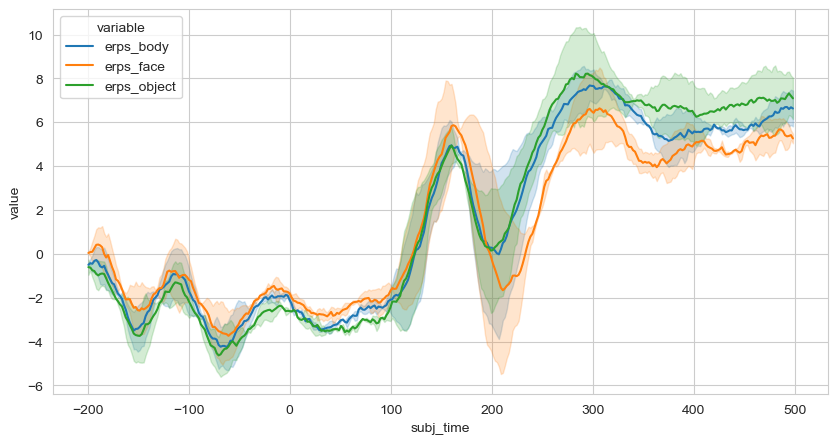

In [623]:
fig, ax = plt.subplots(nrows=1, figsize=(10, 5))
# time_window = df.loc[df['subject'] == 1, 'sub_time']
# time_window
sns.lineplot(data= df2, x='subj_time', y='value', hue='variable')
# sns.lineplot(data= df, x='subj_time', y='erps_object')

### 2. Create time windows to calculate max and min peak

In [667]:
# create the mask time window to look for the maximum peak (P100) and minimum peak (N170)
pos_peak_w = (df2['subj_time'] > 0 ) & (df2['subj_time'] < 200)
neg_peak_w = (df2['subj_time'] > 100 ) & (df2['subj_time'] < 250)
df2[neg_peak_w]

,subj_time,subject,variable,value
154,101.562500,1,erps_body,-2.834496
155,103.515625,1,erps_body,-2.909957
156,105.468750,1,erps_body,-3.071317
157,107.421875,1,erps_body,-3.122304
158,109.375000,1,erps_body,-3.223694
...,...,...,...,...
2015,240.234375,2,erps_object,3.214931
2016,242.187500,2,erps_object,3.473181
2017,244.140625,2,erps_object,3.893928
2018,246.093750,2,erps_object,4.085919


In [671]:
df_pos = df2[pos_peak_w].groupby(['subject','variable'])['value'].agg([max])
df_neg = df2[neg_peak_w].groupby(['subject','variable'])['value'].agg([min])

display(df_pos, df_neg)

max
subject variable             
1       erps_body    4.731100
        erps_face    6.357432
        erps_object  4.229972
2       erps_body    6.104856
        erps_face    7.905890
        erps_object  5.770120

min
subject variable             
1       erps_body   -3.475474
        erps_face   -2.530958
        erps_object -3.514215
2       erps_body   -3.881315
        erps_face   -5.477519
        erps_object -2.695131